In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk

from collections import Counter
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
dv = pd.read_csv("../rawdata/hololivecomments_cleaned.csv")

In [5]:
dv["created_utc"] =  pd.to_datetime(dv["created_utc"]).dt.tz_convert(None)

In [6]:
# Check dataframe

display(dv["submission_id"].count())
display(dv.info())
display(dv.head(1))

2285265

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285265 entries, 0 to 2285264
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   subreddit      object        
 1   id             object        
 2   submission_id  object        
 3   created_utc    datetime64[ns]
 4   author         object        
 5   score          float64       
 6   body           object        
 7   parent_id      object        
 8   permalink      object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 156.9+ MB


None

,subreddit,id,submission_id,created_utc,author,score,body,parent_id,permalink
0,Hololive,ff4gful,erj4fp,2020-01-20 23:30:06,raystrife96,4.0,uptodate rushia year outfit permanent pretty s...,t3_erj4fp,/r/Hololive/comments/erj4fp/i_have_some_questi...


In [7]:
# Function and Procedure

tokenSpace = tokenize.WhitespaceTokenizer()

def counter(text, columnText, quantity): # counter(dv[dv["score"] == 1], "body", 10)
    allWords = ' '.join([text for text in text[columnText].astype('str')])
    tokenPhrase = tokenSpace.tokenize(allWords)
    frequency = nltk.FreqDist(tokenPhrase) 
    dfFrequency = pd.DataFrame({columnText: list(frequency.keys()), "Frequency": list(frequency.values())}) 
    
    dfFrequency = dfFrequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = dfFrequency, x = columnText, y = "Frequency", palette="deep")
    ax.set(ylabel = "Count")
    ax.set_title('Top {} in {} Where (Certain Condition)'.format(quantity, columnText))
    plt.xticks(rotation='horizontal')
    plt.show()
    
def wordappear_permonth(word):
    # convert the body column to strings to ensure that the regular expression search works correctly
    dv['body'] = dv['body'].astype(str)

    # create a new column that contains a boolean indicating whether the word appears in the body attribute
    dv['contains_word'] = dv['body'].apply(lambda x: True if re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) else False)

    # group the DataFrame by the year and month of the created_utc attribute, and count the number of rows in each group where the word appears in the body
    word_counts = dv[dv['contains_word'] == True].groupby(dv['created_utc'].dt.to_period('M')).size()

    # convert the Period objects to timestamps
    word_counts.index = word_counts.index.to_timestamp()

    # create the bar plot
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(word_counts.index, word_counts, width=20)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Appearances of "{}"'.format(word))
    ax.set_title('Number of "{}" Appearances by Month'.format(word))

    # rotate x-axis labels
    plt.xticks(rotation=90, ha='right')

    plt.show()
    
def top_authormention(word, quantity):
    # Convert the body column to strings to ensure that the regular expression search works correctly
    dv['body'] = dv['body'].astype(str)

    # Create a new column that contains a boolean indicating whether the word appears in the body attribute
    dv['contains_word'] = dv['body'].apply(lambda x: True if re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) else False)

    # Group the DataFrame by author and count the number of rows in each group where the word appears in the body
    word_counts = dv[dv['contains_word'] == True].groupby('author').size().sort_values(ascending=False)[:quantity]

    # Create the bar plot
    fig, ax = plt.subplots()
    ax.bar(word_counts.index, word_counts)
    ax.set_xlabel('Author')
    ax.set_ylabel('Number of Appearances of "{}"'.format(word))
    ax.set_title('Top {} Authors Mentioning "{}"'.format(quantity, word))

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    plt.show()
    
def top_authormentionlistofwords(those_words, quantity): # those_words need to be a list of str
    # convert the body column to strings to ensure that the regular expression search works correctly
    dv['body'] = dv['body'].astype(str)

    # create a new column that contains a boolean indicating whether any of the those words appears in the body attribute
    dv['contains_those_words'] = dv['body'].apply(lambda x: True if any(re.search(r'\b{}\b'.format(word), x, re.IGNORECASE) for word in those_words) else False)

    # group the DataFrame by author, and count the number of rows in each group where a those word appears in the body
    those_words_counts = dv[dv['contains_those_words'] == True].groupby('author').size().sort_values(ascending=False)[:10]

    # create the bar plot
    fig, ax = plt.subplots()
    ax.bar(those_words_counts.index, those_words_counts)
    ax.set_xlabel('Author')
    ax.set_ylabel('Number of Appearances of Words Similat to "{}"'.format(those_words[0]))
    ax.set_title('Top {} Authors by Number of Appearances of Words Similar to "{}"'.format(quantity, those_words[0]))
    plt.xticks(rotation=45, ha='right')
    plt.show()

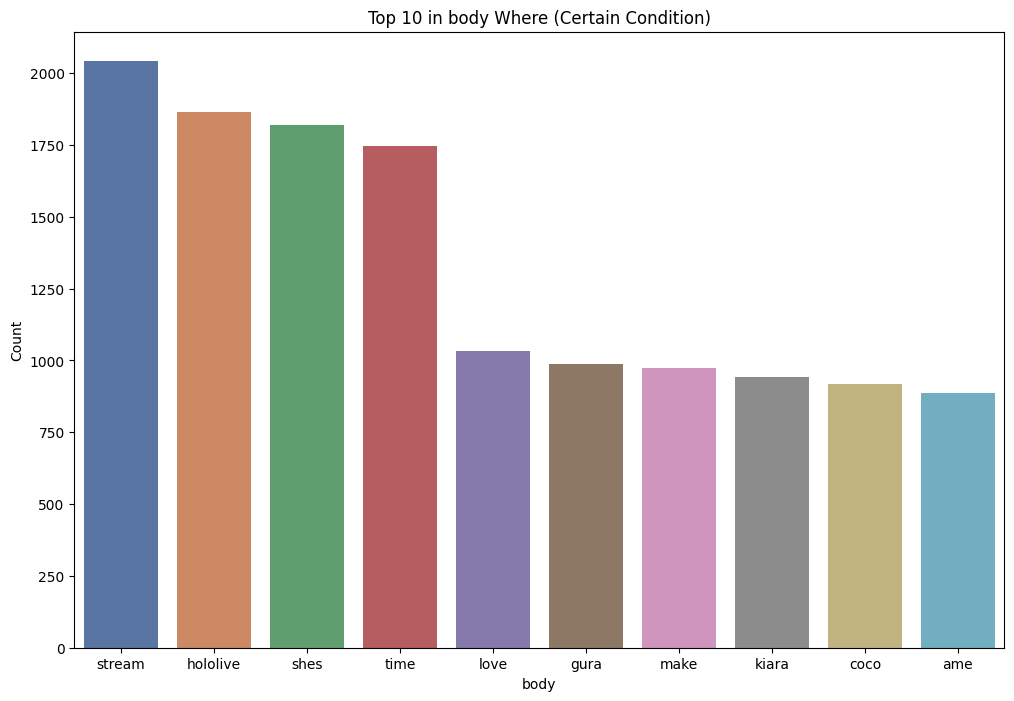

In [8]:
# Plot grafik yang menunjukkan 10 kata yang paling sering
# muncul untuk komentar yang skornya lebih dari 250

counter(dv[dv["score"] >= 250], "body", 10)

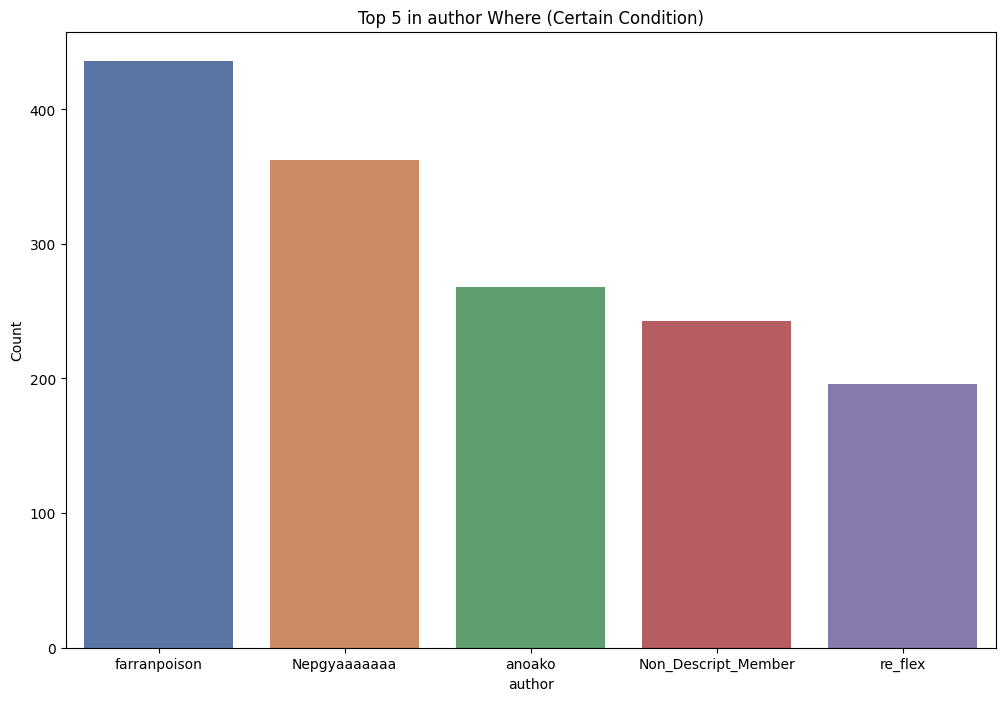

In [9]:
# Plot grafik yang menunjukkan 5 user/author yang paling sering
# berkomentar untuk komentar yang skornya lebih dari 250

counter(dv[dv["score"] >= 250], "author", 5)

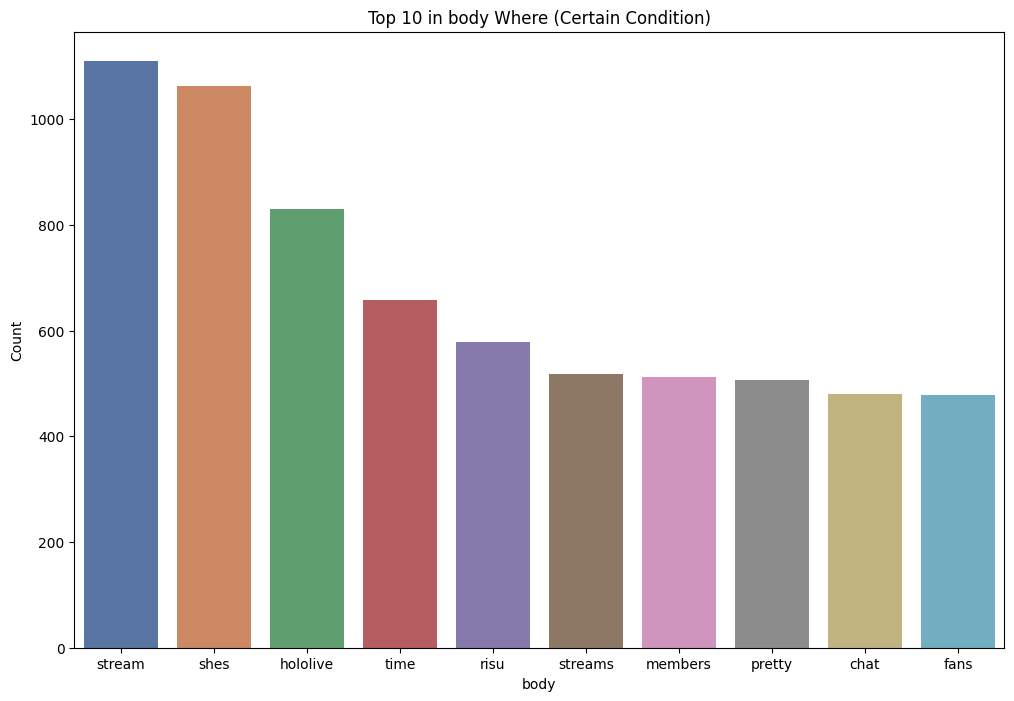

In [10]:
# Menunjukkan 10 kata yang paling sering digunakan oleh "farranpoison"
# atau user paling banyak komentar

counter(dv[dv["author"] == "farranpoison"], "body", 10)

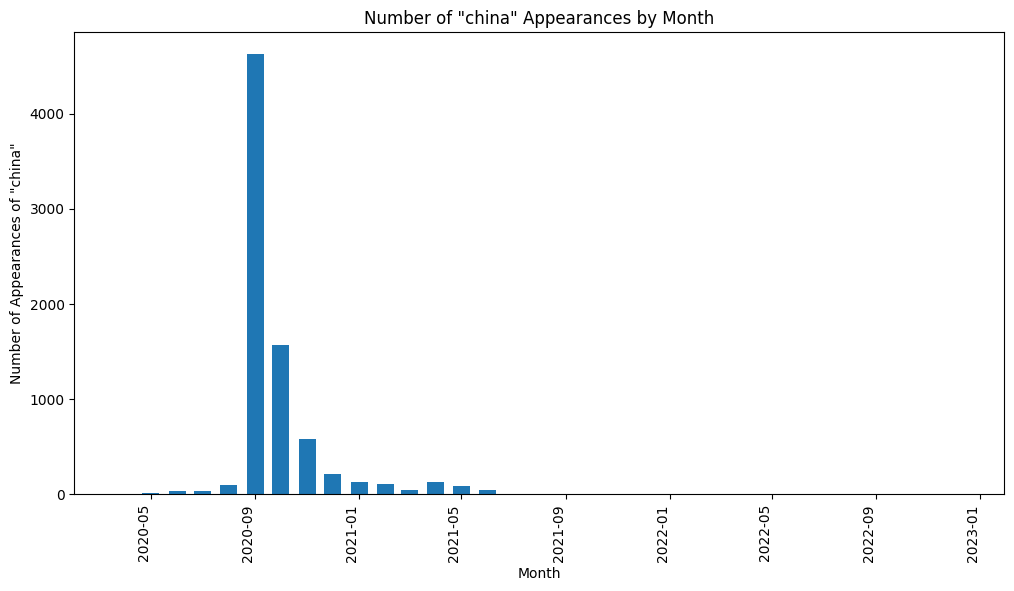

In [11]:
wordappear_permonth("china") # liat desain di Kibana, buat desain interface yang kemungkinan dimengerti orang
# assuming kita sebagai user karena kalau desain itu bergantung kebutuhan user

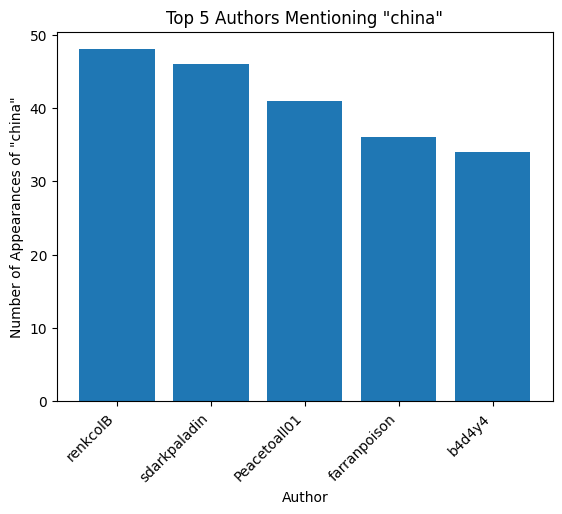

In [12]:
top_authormention("china", 5)

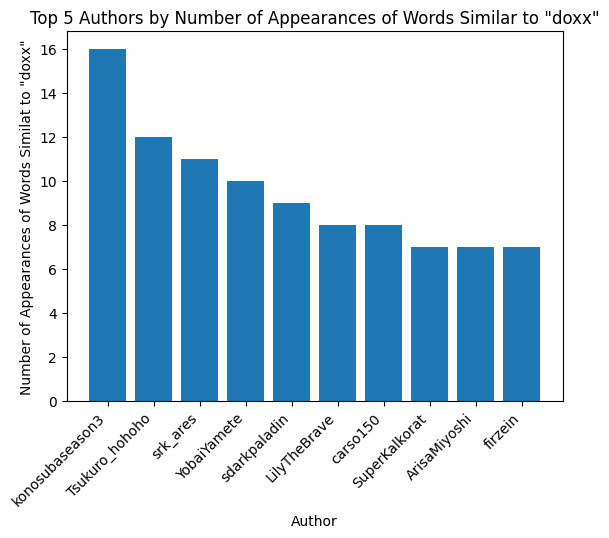

In [13]:
# define the list of those words you want to search for in the body attribute
those_words = ['doxx', 'harass', 'threat']

top_authormentionlistofwords(those_words, 5)
